In [13]:
import os
import sys
import pandas as pd
import numpy as np
import argparse
import datetime
import time
from sklearn import metrics
from collections import defaultdict
import torch
import torch.nn as nn
from torch import nn, Tensor
from typing import List
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.dataset import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# read data
pairdata, freqpairs, n_size, n_interval = get_fb_data(1000)
sizedata = get_data(pairdata, freqpairs, 'size_index', n_size)

In [15]:
seq_set = defaultdict(list)
target_set = defaultdict(list)
size_set = {}

for pair in range(1000):
    size_index = pairdata[freqpairs[pair]].size_index.values
    target_index = np.concatenate((size_index[1:], size_index[0:1]))
    for i in range(len(size_index) - 8):
        seq_set[pair].append(size_index[i:i+8])
        target_set[pair].append(target_index[i:i+8])
        size_set[pair] = sizedata[pair]
    seq_set[pair] = np.array(seq_set[pair])
    target_set[pair] = np.array(target_set[pair])

In [16]:
def sample_dataset(seed):
    np.random.seed(seed)
    dataset = []
    for pair in range(1000):
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size_set[pair], target_set[pair][ran_index]])
    return dataset

def inputTensor(lines):
    tensor = torch.zeros(lines.shape[1], lines.shape[0], n_size, dtype=torch.long)
    for line in range(lines.shape[0]):
        for i in range(lines.shape[1]):
            size = lines[line][i]
            tensor[i][line][size] = 1
    return tensor

dataset = sample_dataset(0)
dataloader = DataLoader(dataset[:32], batch_size=32, shuffle=False)

In [17]:
class SizeToHidden(nn.Module):
    def __init__(self, input_size, hidden_dims, hidden_size, n_layer):
        super(SizeToHidden, self).__init__()
        self.lins = nn.ModuleList()
        self.n_layer = n_layer
        self.hidden_size = hidden_size
        in_dim = input_size 
        for h_dim in hidden_dims:
            self.lins.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(in_dim, out_features=hidden_size * n_layer)

    def forward(self, x: Tensor) -> List[Tensor]:
        for lin in self.lins:
            x = lin(x)
        x = self.output(x)
        x = x.view(-1, 2, self.hidden_size)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [18]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, n_layer)
        self.h2o = nn.Linear(hidden_size, n_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.h2o(out)
        out = self.softmax(out)
        return out, hidden

In [19]:
hidden_size = 512
gru = GRU(n_size, hidden_size, 2).to(device)
s2h = SizeToHidden(n_size, [32, 64, 128], hidden_size, 2).to(device)

In [20]:
seq_tensor, size_tensor, target_tensor = next(iter(dataloader))
seq_tensor = inputTensor(seq_tensor).float().to(device)
size_tensor = size_tensor.float().to(device)
target_tensor = target_tensor.T.long().to(device)

In [21]:
def train(dataloader, optimizer):
    gru.train()
    s2h.train()
    sum_loss = 0
    for seq_tensor, size_tensor, target_tensor in dataloader:
        seq_tensor = inputTensor(seq_tensor).float().to(device)
        size_tensor = size_tensor.float().to(device)
        target_tensor = target_tensor.T.long().to(device)
        optimizer.zero_grad()
        output, hn = gru(seq_tensor, s2h(size_tensor))
        loss = 0
        for i in range(8):
            loss += nn.NLLLoss()(output[i], target_tensor[i])
        loss.backward()
        optimizer.step()
        sum_loss += loss.item() / seq_tensor.shape[0] * seq_tensor.shape[1]
    return sum_loss / len(dataloader.dataset)

In [22]:
lr = 1e-3
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    dataloader = DataLoader(dataset[:1000], batch_size=1000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.3:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 2.3606510162353516 2.4871399211883545 7.630752086639404
200 2.337522029876709 2.3421318554878234 15.1015043258667
300 2.316504955291748 2.3325484824180602 22.63513445854187
400 2.3277180194854736 2.3305913829803466 29.303078174591064
500 2.34124755859375 2.3262123441696168 36.03553533554077
600 2.3333215713500977 2.3252388191223146 42.206469774246216
700 2.3093152046203613 2.324979603290558 49.31947469711304
800 2.3331458568573 2.323228316307068 56.15637278556824
900 2.323852062225342 2.3236997961997985 63.11879301071167
1000 2.3378725051879883 2.3220830249786375 70.82154369354248
1100 2.3311243057250977 2.3195905303955078 77.6230046749115
1200 2.3114726543426514 2.3185447883605956 85.05819034576416
1300 2.328340530395508 2.318561806678772 93.3337299823761
1400 2.326587438583374 2.31739280462265 99.7317304611206
1500 2.315302610397339 2.3167378377914427 105.5874674320221
1600 2.325039863586426 2.315819251537323 112.93643999099731
1700 2.3183064460754395 2.31498744726181 120.7621593

In [10]:
softmax = nn.Softmax(dim=2).to(device)
def sample(size_data, seq_length, start_size=8):
    gru.eval()
    s2h.eval()
    with torch.no_grad():  # no need to track history in sampling
        size_tensor = torch.tensor(size_data, dtype=torch.float).to(device)
        hn = s2h(size_tensor)
        output_seq = [start_size]
        size = start_size
        for _ in range(seq_length - 1):
            input = inputTensor(np.array([[size]])).to(device)
            input = input.float()
            output, hn = gru(input, hn)
            output = softmax(output)
            p_size = output.detach().cpu().numpy().squeeze()
            size = np.random.choice(n_size, p=p_size)
            output_seq.append(size)
        return output_seq

def is_subarray(arr1, arr2):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    for i in range(len(arr1) - len(arr2) + 1):
        if np.array_equal(arr1[i:i+len(arr2)], arr2):
            return True
    return False

In [11]:
pair = 0
start_size = 8
for i in range(100):
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))
    a = sample(sizedata[pair], 8, start_size)
    print(a, is_subarray(size_index, a))

[8, 19, 7, 16, 3, 6, 15, 2] False
[8, 25, 11, 6, 17, 22, 18, 17] False
[8, 5, 20, 29, 18, 9, 24, 25] False
[8, 12, 12, 28, 21, 0, 12, 2] False
[8, 29, 17, 19, 10, 19, 17, 23] False
[8, 26, 12, 26, 1, 20, 6, 16] False
[8, 23, 22, 21, 14, 5, 6, 16] False
[8, 13, 29, 9, 2, 21, 29, 23] False
[8, 7, 1, 12, 26, 12, 8, 28] False
[8, 23, 18, 0, 27, 20, 6, 0] False
[8, 0, 27, 20, 21, 17, 16, 13] False
[8, 17, 19, 11, 19, 13, 2, 6] False
[8, 2, 9, 18, 11, 21, 20, 4] False
[8, 4, 1, 7, 10, 2, 18, 21] False
[8, 4, 10, 21, 19, 25, 16, 0] False
[8, 1, 2, 15, 22, 0, 13, 24] False
[8, 19, 16, 17, 26, 17, 12, 21] False
[8, 10, 29, 26, 4, 20, 1, 26] False
[8, 25, 15, 3, 18, 7, 18, 20] False
[8, 3, 14, 17, 7, 6, 19, 22] False
[8, 10, 21, 17, 24, 6, 23, 8] False
[8, 8, 29, 1, 5, 15, 11, 7] False
[8, 20, 19, 28, 26, 29, 10, 1] False
[8, 9, 14, 5, 2, 13, 27, 22] False
[8, 9, 26, 20, 13, 7, 17, 5] False
[8, 22, 28, 19, 21, 4, 22, 14] False
[8, 2, 11, 21, 17, 9, 29, 17] False
[8, 28, 16, 16, 1, 3, 18, 21] Fal

KeyboardInterrupt: 

In [12]:
from scipy.stats import entropy
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

s2s_pair, size_trans = get_trans(pairdata, freqpairs, 'size_index', n_size)

In [13]:
rnn_jsds, he_jsds = [], []
for pair in range(1000):
    size_data = sizedata[pair]
    size_index = np.concatenate((pairdata[freqpairs[pair]].size_index.values, pairdata[freqpairs[pair]].size_index.values[0:1]))

    for seed in range(100):
        np.random.seed(seed)
        torch.manual_seed(seed)
        start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = [start_size]
        while len(size_seq_gen) < 1000:
            new_size = sample(size_data, 8, start_size=start_size)
            if set(new_size).issubset(np.unique(pairdata[freqpairs[pair]].size_index.values)):
                size_seq_gen += list(new_size[1:])
                start_size = new_size[-1]
                if seed > 10:
                    start_size = np.random.choice(np.arange(30), p=sizedata[pair])
        size_seq_gen = np.array(size_seq_gen)
        values, counts = np.unique(size_seq_gen, return_counts=True)
        new_size = np.zeros(n_size, dtype=float)
        new_size[values] = counts
        new_size /= new_size.sum()

        rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
        values, counts = np.unique(rnn_s2s_pair, return_counts=True)
        rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
        rnn_s2s_pair[values] = counts
        rnn_s2s_pair /= rnn_s2s_pair.sum()
        
        # print(seed, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]))
        if JSD(new_size, sizedata[pair]) < 0.05:
            break

    rnn_s2s_pair = [size_seq_gen[:-1] * n_size + size_seq_gen[1:]]  
    values, counts = np.unique(rnn_s2s_pair, return_counts=True)
    rnn_s2s_pair = np.zeros(n_size ** 2, dtype=float)
    rnn_s2s_pair[values] = counts
    rnn_s2s_pair /= rnn_s2s_pair.sum()

    he_size_seq = []
    while len(he_size_seq) < 1000:
        size = np.random.choice(np.arange(30), p=sizedata[pair])
        he_size_seq.append(size)
    he_size_seq = np.array(he_size_seq)

    he_s2s_pair = [he_size_seq[:-1] * n_size + he_size_seq[1:]]  
    values, counts = np.unique(he_s2s_pair, return_counts=True)
    he_s2s_pair = np.zeros(n_size * n_size, dtype=float)
    he_s2s_pair[values] = counts
    he_s2s_pair /= he_s2s_pair.sum()

    print(pair, JSD(new_size, sizedata[pair]), JSD(rnn_s2s_pair, s2s_pair[pair]), JSD(he_s2s_pair, s2s_pair[pair]))
    rnn_jsds.append(JSD(rnn_s2s_pair, s2s_pair[pair]))
    he_jsds.append(JSD(he_s2s_pair, s2s_pair[pair]))

0 8.683924189704679e-05 0.0022910055284155904 0.026759625955232017
1 0.004099680423816764 0.01456277943562591 0.23650145293333028
2 0.04470496112358387 0.08037020143473747 0.33721434353166024
3 0.00043561584355844996 0.0019475070128023536 0.3462488346412111
4 0.006056248010429628 0.012005518635222505 0.18358827226755522
5 0.017016281948989687 0.038041371616718715 0.2937974611418298
6 0.00874599419702543 0.011870306801960172 0.12237091430858037
7 0.007250752866105811 0.04307198830517407 0.28260513058765857
8 0.002846447107120527 0.02619473574740403 0.29456985171632805
9 0.013895179550947804 0.04594797656483342 0.2794249364570428
10 0.008878255676328061 0.010904393389825197 0.06903145299100663
11 0.04907119199785718 0.06600896828200971 0.2731012455916101
12 0.008602377043349528 0.01465406970493979 0.06125081041976111
13 0.002403147294469263 0.033308766691192 0.177964247814853
14 0.0 0.0 0.0
15 0.01928682043648037 0.02693250059550536 0.16208903034875155
16 0.019671193890775655 0.040124018

KeyboardInterrupt: 

(0.0, 1.05)

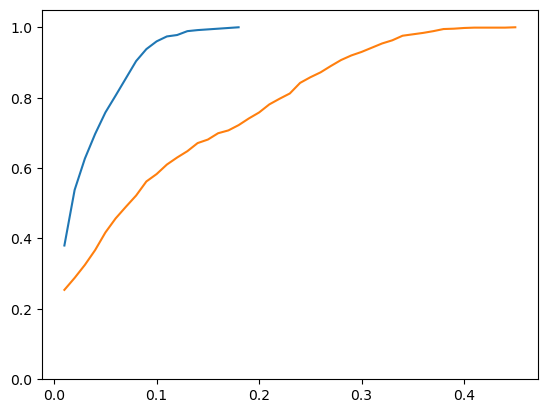

In [40]:
import matplotlib.pyplot as plt

values, bins = np.histogram(rnn_jsds, bins=np.arange(0, np.max(rnn_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

values, bins = np.histogram(he_jsds, bins=np.arange(0, np.max(he_jsds) + 0.01, 0.01))
cdf = np.cumsum(values) / np.sum(values)
plt.plot(bins[1:], cdf)

plt.ylim(0, 1.05)

In [41]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.016796066997483282 0.07346432855368562
90 0.07909204873483928 0.2751986895385197
95 0.09532450370252392 0.31491465589104833
99 0.1320168295307611 0.3700949495105308


In [136]:
for i in [50, 90, 95, 99]:
    print(i, np.percentile(rnn_jsds, i), np.percentile(he_jsds, i))

50 0.012160265192768834 0.07145898533012404
90 0.047915725836543216 0.2727736298325866
95 0.053717750535610495 0.3153216864822403
99 0.06597230544940674 0.36794891171362076


In [10]:
# torch.save(gru, 'models/gru-0504.pth')
# torch.save(s2h, 'models/s2h-0504.pth')

In [11]:
class SizeDecoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dims, latent_dim):
        super(SizeDecoder, self).__init__()
        self.decoder = torch.nn.ModuleList()
        in_dim = latent_dim
        for h_dim in hidden_dims:
            self.decoder.append(
                nn.Sequential(
                    nn.Linear(in_dim, out_features=h_dim,),
                    nn.ReLU())
            )
            in_dim = h_dim
        self.output = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, x: Tensor) -> List[Tensor]:
        for module in self.decoder:
            x = module(x)
        result = self.output(x)
        result = F.softmax(result, dim=1)
        return result
    
decoder = torch.load('models/size-decoder-0425.pth')
gru = torch.load('models/gru-0504.pth')
s2h = torch.load('models/s2h-0504.pth')

In [50]:
from scipy.stats import entropy
from tqdm import tqdm
def JSD(p, q):
    p = list(p)
    q = list(q)
    pq_max_len = max(len(p), len(q))
    p += [0.0] * (pq_max_len - len(p))
    q += [0.0] * (pq_max_len - len(q))
    assert (len(p) == len(q))
    m = np.sum([p, q], axis=0) / 2
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

def sample_noisy_dataset(n, seed):
    torch.manual_seed(seed)
    dataset = []
    for i in tqdm(range(n)):
        latent_dim = 32
        z = torch.randn((1, latent_dim)).to(device)
        size = decoder(z)
        size = size.squeeze().detach().to('cpu').numpy()
        size[size < 1e-3] = 0
        size /= size.sum()

        dis = []
        for j in range(1000):
            loss = JSD(size, sizedata[j])
            dis.append(loss)

        pair = np.argmin(dis)
        ran_index = np.random.randint(len(seq_set[pair]))
        dataset.append([seq_set[pair][ran_index], size, target_set[pair][ran_index]])
        
    return dataset

In [71]:
a = []
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)

    pair = np.argmin(dis)
    a.append(pair)

100%|██████████| 5000/5000 [05:13<00:00, 15.93it/s]


In [47]:
lr = 1e-3
# optimizer = torch.optim.Adam([{'params': s2h.parameters()}], lr=lr)
optimizer = torch.optim.Adam([{'params': gru.parameters()}, {'params': s2h.parameters()}], lr=lr)

s_time = time.time()
plot_every = 100
avg_loss = 0
for i in range(1000001):
    dataset = sample_dataset(i)
    ran_index = np.random.permutation(len(tune_dataset))[0:1000]
    # dataset.extend([tune_dataset[i] for i in ran_index])
    dataloader = DataLoader(dataset, batch_size=2000, shuffle=True)
    loss = train(dataloader, optimizer)
    avg_loss += loss
    if i and i % plot_every == 0:
        print(i, loss, avg_loss / plot_every, time.time() - s_time)
        if avg_loss / plot_every < 0.1:
            print(i, avg_loss / plot_every)
            break
        avg_loss = 0

100 0.37469881772994995 0.36950908958911893 11.19027829170227
200 0.36915746331214905 0.35975850641727447 21.188878059387207
300 0.35969191789627075 0.35673402369022367 32.09577918052673


KeyboardInterrupt: 

In [74]:
from tqdm import tqdm
a = set()
for i in tqdm(range(1000)):
    torch.manual_seed(i)
    latent_dim = 32
    z = torch.randn((1, latent_dim)).to(device)
    size = decoder(z)
    size = size.squeeze().detach().to('cpu').numpy()
    size[size < 1e-3] = 0
    size /= size.sum()

    dis = []
    for j in range(1000):
        loss = JSD(size, sizedata[j])
        dis.append(loss)
        # if loss < 0.02:
        #     a.add(j)

    pair = np.argmin(dis)
    a.add(pair)

100%|██████████| 1000/1000 [00:58<00:00, 17.09it/s]


In [73]:
jsds = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        jsds[i][j] = JSD(sizedata[i], sizedata[j])

In [75]:
np.sort(jsds[8])

array([0.        , 0.0712686 , 0.0989841 , 0.10461984, 0.10732551,
       0.11061315, 0.11413909, 0.11538036, 0.11660952, 0.11782312,
       0.12270552, 0.12357579, 0.12381709, 0.12831985, 0.12900488,
       0.13021052, 0.13290488, 0.13328528, 0.13464494, 0.13588953,
       0.13698097, 0.13924533, 0.14027519, 0.14082266, 0.14095486,
       0.14102039, 0.14222849, 0.14290341, 0.14387662, 0.14660579,
       0.14678407, 0.14694698, 0.14717077, 0.14719107, 0.14890525,
       0.14939437, 0.14958512, 0.15188435, 0.1524103 , 0.15251156,
       0.15369764, 0.1559504 , 0.15639397, 0.15688702, 0.15898742,
       0.15899087, 0.16149691, 0.16396171, 0.16474164, 0.16477304,
       0.1657369 , 0.16581361, 0.16621777, 0.16631866, 0.1666306 ,
       0.16702055, 0.16783559, 0.16789516, 0.16937711, 0.16999767,
       0.17006917, 0.17089419, 0.17237322, 0.17269899, 0.17295262,
       0.17311279, 0.1738042 , 0.17434601, 0.17441435, 0.17492409,
       0.17498089, 0.17590966, 0.17673751, 0.1767769 , 0.17685

In [65]:
(jsds < 0.01).sum(axis=1)

array([  2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   3,   1,   1,  95,   1,   1,   1,   1,   1,   2,   1,  96,
         1,   1,   1,   4,   1,   2,   1,   1,   1,   1,   2,   1,   3,
         1,   1,   1,   2,   3,   1,   1,   2,   4,   2,   1,   1,   1,
         2,   1,   2,   1,   1,   1,   1,   1,   1,   1,   4,   3,   1,
         3,   1,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   3,
         1,   1,   6,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   3,   1,   1,   1,   1,   1,   1,   6,
         2,   1,   1,   4,   1,   2,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  76,   2,   1,   1,  29,   1,
         1,   4,   5,   1,   1,   1,   1,   1,   2,   1,   1,   5,   7,
         4,   1,   2,   1,   5,   1,   4,   1,   1,   1,   1,  20,   7,
         5,   1,   1,   1,   1,   1,   1,   1,   5,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   4,   2,   1,   1,   1,   1,   